In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Data/hawaii.sqlite")
insp = inspect(engine)

In [23]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [24]:
# View all of the classes that automap found
print(insp.get_table_names())

['measurement', 'station']


In [25]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
sesh = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
columns = insp.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])
most_recent = engine.execute('SELECT max(date) FROM measurement').fetchall()
most_recent = most_recent[0][0]
print(f'the most recent date taken in the database was taken on {most_recent}')

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
the most recent date taken in the database was taken on 2017-08-23


one year from the last taken date: 2017-08-23 would be: 2016-08-23


NameError: name 'result' is not defined

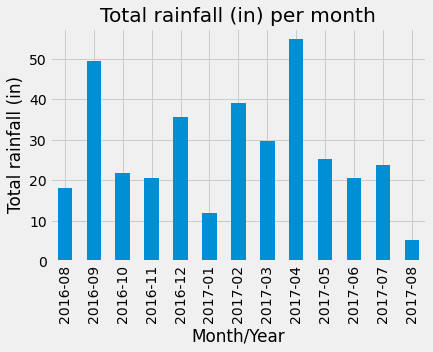

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
import datetime as dt
start_date = dt.datetime(2016, 8, 23)

# Calculate the date one year from the last date in data set.
print(f'one year from the last taken date: {most_recent} would be: 2016-08-23')

# Perform a query to retrieve the data and precipitation scores
results = sesh.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= start_date).all()

results

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp = [{'date': result[0], 'precipitation': result[1]} for result in results]
prcp
# Sort the dataframe by date
precip_df = pd.DataFrame(prcp)
precip_df = precip_df.dropna()
# Use Pandas Plotting with Matplotlib to plot the data
precip_df['date'] = pd.to_datetime(precip_df['date'])
precip_df['month/year'] = precip_df['date'].apply(lambda x: x.strftime('%Y-%m'))
precip_df.groupby('month/year')['precipitation'].sum().plot.bar()
plt.xlabel('Month/Year')
plt.ylabel('Total rainfall (in)')
plt.title('Total rainfall (in) per month');


In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.groupby('month/year')['precipitation'].describe()

,count,mean,std,min,25%,50%,75%,max
month/year,,,,,,,,
2016-08,47.0,0.385106,0.708050,0.0,0.005,0.08,0.2250,2.46
2016-09,173.0,0.285549,0.662214,0.0,0.010,0.07,0.2700,6.70
2016-10,179.0,0.121620,0.344809,0.0,0.000,0.01,0.0800,3.46
2016-11,171.0,0.120234,0.342695,0.0,0.000,0.02,0.0900,2.87
2016-12,178.0,0.199494,0.342967,0.0,0.020,0.06,0.2475,2.37
2017-01,170.0,0.070294,0.276047,0.0,0.000,0.00,0.0175,2.64
2017-02,162.0,0.241111,0.672922,0.0,0.000,0.00,0.0600,5.04
2017-03,169.0,0.175266,0.431165,0.0,0.000,0.00,0.0800,2.40
2017-04,171.0,0.321111,0.702469,0.0,0.000,0.02,0.3100,6.25


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
columns = insp.get_columns('station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [31]:
stations = engine.execute('SELECT count(station) FROM station').fetchall()[0][0]
print(f'There are a total of: {stations} stations')

There are a total of: 9 stations


In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = sesh.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
calcs = sesh.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()
lowest = calcs[0][0]
highest = calcs[0][1]
average = round(calcs[0][2],2)

In [34]:
print('At station USC00519281:')
print(f'The lowest recorded temp is {lowest}')
print(f'The highest recorded temp is {highest}')
print(f'The average of all recorded temps is {average}')

At station USC00519281:
The lowest recorded temp is 54.0
The highest recorded temp is 85.0
The average of all recorded temps is 71.66


In [59]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
starte_date = dt.datetime(2016,8,18)

temps = sesh.query(measurement.station, measurement.date, measurement.tobs).\
filter(measurement.station == 'USC00519281', measurement.date >= start_date).all()
temps_list = [{'station':temp[0], 'date':temp[1], 'temp':temp[2]} for temp in temps]
temps_df = pd.DataFrame(temps_list)
temps_df

,station,date,temp
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0
...,...,...,...
346,USC00519281,2017-08-14,77.0
347,USC00519281,2017-08-15,77.0
348,USC00519281,2017-08-16,76.0
349,USC00519281,2017-08-17,76.0


<AxesSubplot:ylabel='Frequency'>

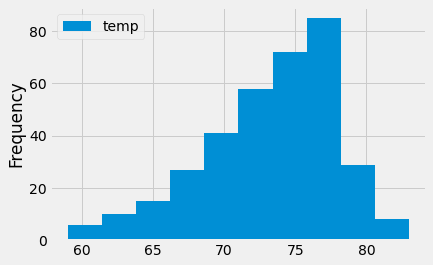

In [60]:
temps_df.plot.hist()

# Close session

In [18]:
# Close Session
sesh.close()